In [5]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os

todo: put this together with the stuff of part A? They are itself relativly selfe explanitory

TODO: sollten am schluss noch eine requirements.txt dazulegen und die pyhton version spezifizieren. Nutze 3.12 gerade

TODO: get_path_model() und get_path_scene() müssen ne Fehlermeldung zurückgeben, wenn's das Bild nicht gibt

In [6]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def is_point_in_rectangle(p, rect):

    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude_squared(v):
        return v[0]**2 + v[1]**2
    
    # Unpack rectangle vertices
    A, B, C, D = rect
    
    # Compute vectors
    AB = vector(A, B)
    AD = vector(A, D)
    AP = vector(A, p)
    
    # Check if the point projects within both sides of the rectangle
    within_AB = 0 <= dot_product(AP, AB) <= magnitude_squared(AB)
    within_AD = 0 <= dot_product(AP, AD) <= magnitude_squared(AD)
    
    return within_AB and within_AD

These functions are used to visualize some of the individual steps.

In [23]:
def plot_images(image_paths):

    images = [cv.imread(p) for p in image_paths]

    # Check if the list is empty
    if not images:
        raise ValueError("The list of images is empty.")
    
    # Find the maximum height among all images
    max_height = max(img.shape[0] for img in images)
    
    # Resize all images to have the same height
    resized_images = [
        cv.resize(img, (int(img.shape[1] * max_height / img.shape[0]), max_height))
        for img in images
    ]
    
    # Horizontally concatenate images
    concatenated_image = np.hstack(resized_images)
    print([os.path.split(p)[-1] for p in image_paths])
    plt.imshow(cv.cvtColor(concatenated_image, cv.COLOR_BGR2RGB))
    plt.title("models")
    plt.show()

def draw_good_and_bad_matches(scene, good, bad, kp_scene):
#draw excluded and included matches
        for o in bad:
            x,y = kp_scene[o.trainIdx].pt
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,0,255), 4)

        for o in good:
            x,y = kp_scene[o.trainIdx].pt  # Get match coordinates
            coord = [int(x), int(y)]
            cv.circle(scene, coord, 3, (0,255,0), 4)

        plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
        plt.title("grid with good and bad (excluded) matches")
        plt.show()

def draw_matches(model, kp_model, scene, kp_scene, good):
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                        singlePointColor = None, # not draw keypoints only matching lines
                        matchesMask = None, # draw only inliers
                        flags = 2) # not draw keypoints only lines
    img3 = cv.drawMatches(model, kp_model, scene, kp_scene, good, None,**draw_params)
    plt.title("Correlating matches")
    plt.imshow(img3)
    plt.show()

def draw_barycenter_predictions(scene, barygrid_cell_width, barygrid_cell_height, barycenter_votes, dst_kp):
    
    for b, d in zip(barycenter_votes, dst_kp):
        d = [int(d.pt[0]), int(d.pt[1])]
        cv.circle(scene, d, 3, (0,255,0), 4)
        cv.circle(scene, b, 3, (255,0,0), 4)
        cv.line(scene, d, b, color=(0, 255, 0), thickness=2)
    
    height, width, _ = scene.shape
    num_vertical_lines = width // barygrid_cell_width
    num_horizontal_lines = height // barygrid_cell_height
    
    for i in range(1, num_vertical_lines):
        x = i * barygrid_cell_width
        cv.line(scene, (x, 0), (x, height), color=(0, 0, 255), thickness=2)

    for i in range(1, num_horizontal_lines+1):
        y = i * barygrid_cell_height
        cv.line(scene, (0, y), (width, y), color=(0, 0, 255), thickness=2)

    plt.imshow(cv.cvtColor(scene, cv.COLOR_BGR2RGB))
    plt.title("Features with their respective joining vectors (green), bins and votes (blue)")
    plt.show()
    
def uniform_grid_sampling_with_descriptors(image, keypoints, descriptors, rows=4, cols=4, top_k=5):
    """
    Performs uniform grid sampling on keypoints and descriptors.

    Args:
        image: The input image (used for determining dimensions).
        keypoints: List of keypoints detected in the image.
        descriptors: Corresponding descriptors for the keypoints.
        rows: Number of rows to divide the image into.
        cols: Number of columns to divide the image into.
        top_k: Maximum number of keypoints/descriptors to keep per grid cell.

    Returns:
        filtered_keypoints: List of filtered keypoints.
        filtered_descriptors: Numpy array of filtered descriptors.
    """
    height, width = image.shape[:2]
    cell_height = height // rows
    cell_width = width // cols

    filtered_keypoints = []
    filtered_descriptors = []

    for i in range(rows):
        for j in range(cols):
            # Define the boundaries of the current grid cell
            x_start, y_start = j * cell_width, i * cell_height
            x_end, y_end = x_start + cell_width, y_start + cell_height

            # Select keypoints within this cell
            cell_keypoints = [(kp, idx) for idx, kp in enumerate(keypoints)
                              if x_start <= kp.pt[0] < x_end and y_start <= kp.pt[1] < y_end]

            # Sort keypoints in the cell by response value
            cell_keypoints = sorted(cell_keypoints, key=lambda kp_idx: kp_idx[0].response, reverse=True)[:top_k]

            # Keep the top_k keypoints and their corresponding descriptors
            for kp, idx in cell_keypoints:
                filtered_keypoints.append(kp)
                filtered_descriptors.append(descriptors[idx])

    # Convert the filtered descriptors to a numpy array
    filtered_descriptors = np.array(filtered_descriptors)

    return filtered_keypoints, filtered_descriptors

To simplify handling the detected products, we decidde to use define a class to wrapp them into a single data structure.

In [8]:
class Product:
  def __init__(self, position, width, height, cornerpoints):
    self.position = position
    self.width = width
    self.height = height
    self.cornerpoints = cornerpoints

# Step B: step by step

In the following cells, we are going to explain our code step by step on an example before defining and executing it all in one function.

The next cells defines our scene and model, as well as some parameters that are going to be important later.

In [9]:
#set parameters for demonstration
scene = "m1.png"
scene_path=get_path_scene(scene)
models = [0, 1, 11, 19, 24, 25, 26]

scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)
scene_color = cv.imread(scene_path) # for illustrative purposes
model_gray = cv.imread(get_path_model(24), cv.IMREAD_GRAYSCALE)


product_result = []

TODO: same as step 1?

In [10]:
MIN_MATCH_PERCENTAGE = 13
MIN_MATCH_COUNT=300

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp_model, des1 = sift.detectAndCompute(model_gray,None)
kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE/100)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

src_kp = [kp_model[m.queryIdx] for m in good]
dst_kp = [kp_scene[m.trainIdx] for m in good]

In this subsection, we are going to make use of the Generalized Hough Transformation in combination with Local Invariant Features, which is also called _Star Model_. Instead of an R-table representing the edges of a shape, the GHT + SIFT uses not only the matched features, but also their position relative to a reference point (in this case: the object's barycenter). Those vectors describing the location relative the the barycenter are called _joining vectors_ and should technically all point to the same position (after a transformation is applied). Features which's joining vectors deviate a lot from the most the most common area might be missmatched and can therefore be discarded which improves the model detection. This _area_ is determent by a grid-based voting mechanism.

The barycenter P<sub>C</sub> is computed by taking the mean of all found features in the model:

P<sub>C</sub> = $\frac{1}{N}$ $\sum_{i=1}^N P_i$ , P being the position of the _i_ th feature.

The following code computes P<sub>C</sub> and stores the joining vectors in an array:

In [11]:
if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:

	# Compute the barycenter
	points = np.array([kp.pt for kp in src_kp], dtype=np.float32)
	barycenter = points.mean(axis=0).astype(int)

	# compute the joining vectors
	points = np.array([kp.pt for kp in src_kp], dtype=np.float32).astype(int)
	joining_vectors = barycenter - points

In this part of the code, for each feature found in the scene the barycenter of the object in the scene is predicted based on the model's joining vector. Because the object in the scene might be scaled and rotated we need to transform the joining vector $V_i$ based on the difference in scale $\Delta S_j$ and rotation $\Delta \varphi_j$ of the feature in the scene. The following formula describes the calculation of the (presumed) barycenter: 

$\tilde{\mathbf{P}}_{C_j} = \tilde{\mathbf{P}}_j + \Delta S_j \cdot R(\Delta \varphi_j) \mathbf{V}_i$


In [12]:
if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:

    barycenter_votes = []

    for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

        jv_x, jv_y = jv

        pt_x, pt_y = d.pt
        delta_s = d.size/s.size

        delta_phi = d.angle - s.angle

        angle_radians = math.radians(delta_phi)
        jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
        jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

        bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
        barycenter_votes.append(bary_predict)

This cell implements the voting. The voting assumes that correctly matched features describe the barycenter at the same position. A 25x25px grid is laid over the image, seperating it in bins. For a feature to be considered its joining vector need to point to a bin with at least 25 votes. This number has proofed well in our testing. The figure shows all matches and where their joining vectors are pointing at. Also, for each winning bin an average of all predicted barycenters is saved in an array called _barygrid_means_ which will be relevant later.

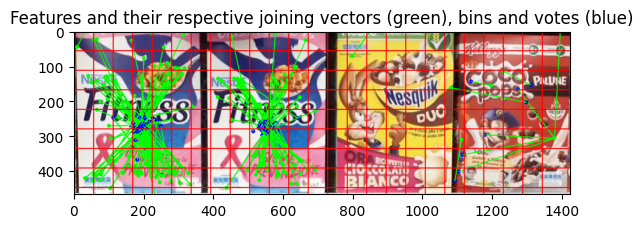

In [24]:
GRID_RESOLUTION=25
MIN_VOTES=25


x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
y_cell = x_cell

y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

# Initialize a 2D array where each element is an empty list
grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

# assign features matches and barycenters to grids
for i in range(0,len(barycenter_votes)):
    bary = barycenter_votes[i]
    # Check if predict Bary center is in Picture
    if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
        x_idx = int(bary[0]/x_cell)
        y_idx = int(bary[1]/y_cell)
        grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
        barygrid[x_idx][y_idx].append(bary)

draw_barycenter_predictions(scene_color.copy(), x_cell, y_cell, barycenter_votes, dst_kp)

# select vote winners in grid
barygrid_means = []
winners = []
for i in range(0,len(grid)):
    for j in range(0,len(grid[i])):
        if len(grid[i][j])>MIN_VOTES:
            winners.append(grid[i][j])
            barygrid_means.append(np.mean(barygrid[i][j], axis=0))

The upper part of the next cell makes use of __barygrid_means__, which contains the mean value of bins who won in the voting, by checking if it lies in an area which must be ignored. Ignored areas are those where an object of the same type has already been found. This is necessary, since a dense cloud of predicted barycenters could be cut in half during the voting depending on the placment of the grid. To prevent looking for the same object twice or thrice, as soon as on object was recognized, we prevent the code from looking for in again in the same area. Looking for the same instance in other places of the scene is still possible.

The lower part uses our filterd matched feature to calculate the the perspective transformation of the model, its homography, by using __cv.findHomography()__. We then use __cv.perspectiveTransform()__ to lay its corners on the scene to visualize it. Since the task suggests a need for the shapes to be rectangular, we adjust them for the wanted shape and add them to the list of results. #TODO hier vllt noch mehr dazu?

here


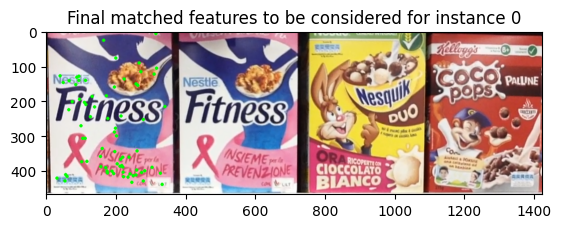

here


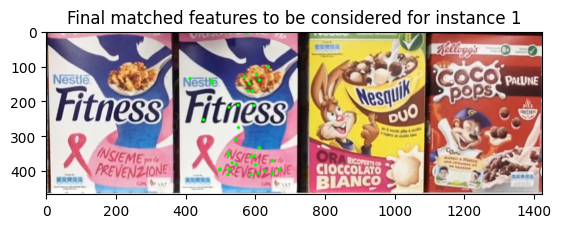

In [25]:
counter = 0

ignored_area = []
for winner, barygrid_mean in zip(winners, barygrid_means):
    

    # check if Winner is in area with already found winner
    winner_found = False
    for rec in ignored_area:
        if is_point_in_rectangle(barygrid_mean, rec):
            winner_found = True
            break

    if winner_found:
        continue

    print("here")
    #USE THIS TO DRAW THE RESULTS FROM POINTS
    src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

    #draw the final matched features to be considered to calculate the homography with
    tmp = scene_color.copy()
    for coord in dst_pts:
        cv.circle(tmp, np.array([o for o in coord[0]], dtype=np.int64), 2, (0,255,0), 5)

    plt.imshow(cv.cvtColor(tmp, cv.COLOR_BGR2RGB))
    plt.title(f"Final matched features to be considered for instance {counter}")
    plt.show()

    counter+=1

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    h,w = model_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv.perspectiveTransform(pts,M)

    # Compute height as the average of two height measurements
    height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

    # Compute width as the average of two width measurements
    width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

    # Compute center X coordinate
    x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

    # Compute center Y coordinate
    y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

    # Create product object and append to result list
    product_result.append(Product((x, y), width, height, dst))

    #add found instance to ignored areas
    ignored_area.append([o[0] for o in np.int32(dst)])


todo: bruno (bisschen erklären einfach)

In [15]:
def product_recognition(scene, result):
    scene_gray = cv.imread(get_path_scene(scene))
    for i in range(len(result)):
        product_results = result[i]
        print(f"Product {models[i]} - {len(product_results)} instance(s) found:")
        for j in range(len(product_results)):
            print("\tInstance {}: position: {}, width: {}px, height: {}px".format(j,
                                                                                  product_results[j].position,
                                                                                  product_results[j].width,
                                                                                  product_results[j].height) )
            cv.rectangle(scene_gray,
                         (product_results[j].position[0] - int(product_results[j].width/2),
                          product_results[j].position[1] - int(product_results[j].height/2)),
                         (product_results[j].position[0] + int(product_results[j].width/2),
                          product_results[j].position[1] + int(product_results[j].height/2)),
                         (0,255,0),3)

    plt.imshow(cv.cvtColor(scene_gray, cv.COLOR_BGR2RGB))
    plt.show()

Product 0 - 2 instance(s) found:
	Instance 0: position: (184, 213), width: 351px, height: 500px
	Instance 1: position: (550, 218), width: 335px, height: 490px


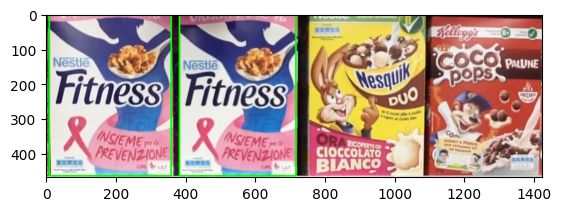

In [16]:
product_recognition(scene,[product_result])

# Step B: As Function

The following cell takes all of our previoursly discussed code snippets and merges them into one functio taking into account to detecting multiple models.

In [17]:
def find_image(scene_path, model_paths, MIN_MATCH_PERCENTAGE = 13, MIN_MATCH_COUNT=300, GRID_RESOLUTION=25, MIN_VOTES=25):
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    result = []

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        product_result = []

        # Apply model preprocessing
        model_gray = model["img"]

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        MIN_MATCH_PERCENTAGE_THRESHOLD = int(len(kp_model) * MIN_MATCH_PERCENTAGE/100)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        src_kp = [kp_model[m.queryIdx] for m in good]
        dst_kp = [kp_scene[m.trainIdx] for m in good]

        if len(good)>=MIN_MATCH_COUNT or len(good)>=MIN_MATCH_PERCENTAGE_THRESHOLD:
            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)

            x_cell = int(scene_gray.shape[1]/GRID_RESOLUTION)
            y_cell = x_cell

            y_cells_n = int(scene_gray.shape[1]//y_cell + 1)

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            barygrid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(y_cells_n)]

            # assign features matches and barycenters to grids
            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                    barygrid[x_idx][y_idx].append(bary)
            # select vote winners in grid
            barygrid_means = []
            winners = []
            
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>MIN_VOTES:
                        winners.append(grid[i][j])
                        barygrid_means.append(np.mean(barygrid[i][j], axis=0))

            ignored_area = []
            for winner, barygrid_mean in zip(winners, barygrid_means):

                # check if Winner is in area with already found winner
                winner_found = False
                for rec in ignored_area:
                    if is_point_in_rectangle(barygrid_mean, rec):
                        winner_found = True
                        break

                if winner_found:
                    continue
                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)

                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                # Compute height as the average of two height measurements
                height = int(((dst[1][0][1] - dst[0][0][1]) + (dst[2][0][1] - dst[3][0][1])) / 2)

                # Compute width as the average of two width measurements
                width = int(((dst[3][0][0] - dst[0][0][0]) + (dst[2][0][0] - dst[1][0][0])) / 2)

                # Compute center X coordinate
                x = int(((dst[3][0][0] - (dst[3][0][0] - dst[0][0][0]) / 2) +
                         (dst[2][0][0] - (dst[2][0][0] - dst[1][0][0]) / 2)) / 2)

                # Compute center Y coordinate
                y = int(((dst[1][0][1] - (dst[1][0][1] - dst[0][0][1]) / 2) +
                         (dst[2][0][1] - (dst[2][0][1] - dst[3][0][1]) / 2)) / 2)

                # Create product object and append to result list
                product_result.append(Product((x, y), width, height, dst))

                #add found instance to ignored areas
                ignored_area.append([o[0] for o in np.int32(dst)])
        result.append(product_result)
    return result




Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 2 instance(s) found:
	Instance 0: position: (184, 213), width: 351px, height: 500px
	Instance 1: position: (550, 218), width: 336px, height: 490px
Product 25 - 0 instance(s) found:
Product 26 - 1 instance(s) found:
	Instance 0: position: (921, 218), width: 333px, height: 486px


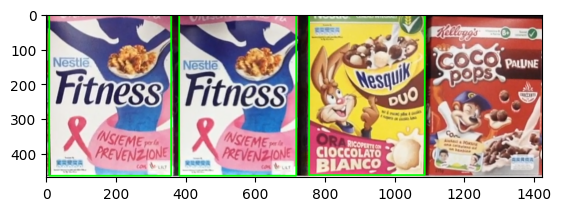

In [18]:
#define models to be searched in image
scene = "m1.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene,result)

Product 0 - 1 instance(s) found:
	Instance 0: position: (178, 300), width: 343px, height: 448px
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:


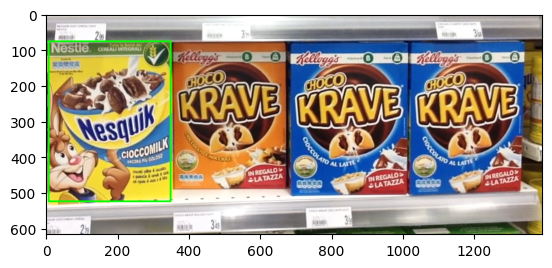

In [19]:
#define models to be searched in image
scene = "m2.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene,result)

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 1 instance(s) found:
	Instance 0: position: (1233, 189), width: 295px, height: 382px
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 1 instance(s) found:
	Instance 0: position: (195, 206), width: 354px, height: 506px


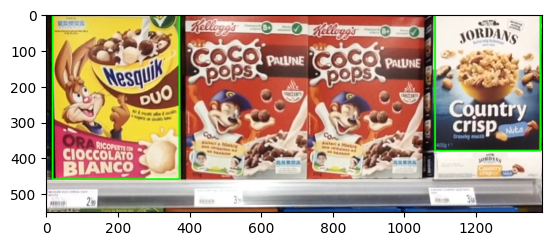

In [20]:
#define models to be searched in image
scene = "m3.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene,result)

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 0 instance(s) found:
Product 24 - 2 instance(s) found:
	Instance 0: position: (161, 190), width: 364px, height: 509px
	Instance 1: position: (540, 196), width: 348px, height: 499px
Product 25 - 0 instance(s) found:
Product 26 - 1 instance(s) found:
	Instance 0: position: (921, 195), width: 341px, height: 493px


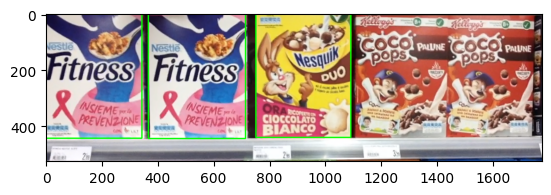

In [21]:
#define models to be searched in image
scene = "m4.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene,result)

Product 0 - 0 instance(s) found:
Product 1 - 0 instance(s) found:
Product 11 - 0 instance(s) found:
Product 19 - 1 instance(s) found:
	Instance 0: position: (908, 190), width: 295px, height: 383px
Product 24 - 0 instance(s) found:
Product 25 - 0 instance(s) found:
Product 26 - 0 instance(s) found:


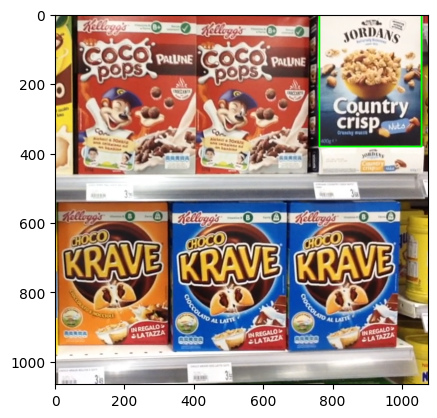

In [22]:
#define models to be searched in image
scene = "m5.png"
models = [0, 1, 11, 19, 24, 25, 26]

result = find_image(scene_path=get_path_scene(scene),
                    model_paths=[get_path_model(a) for a in models])

product_recognition(scene,result)

# Step C

Step C runs on the same code as Step B does, but we refiened the parameters even more to work for the more challenging scenes. We successfully recognized some of the products but recognizing all was not possible, partly because the number of features detected in the scenes were very low for each product, because the scene's resolution were relativly bad.
Since we could not find a dataset containing cereal boxes, machine learning / deep learning approaches were also not possible. 